# Avito Challenge: Stage 2v0 Model
Stage 2 modeling incoprates many inspirations taken from public kernels related to the Avito challenge. Stage 2v0 in particular is based off of https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-notebook-avito. This this kernel, a relatively simple preprocessing is used in conjunction with a simple Light GBM model.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

In [2]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [3]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

# Light GBM parameters
model_path_2 = setup_params['model_dir_2']

# Training and test sets
labels_path = setup_params['train_labels']
train_data_path = setup_params['stage0_train']

test_data_path = setup_params['stage0_test']
test_items_path = setup_params['test_items']

In [4]:
# Original training and test dataframes
train_df = pd.read_csv(train_csv_path, parse_dates=['activation_date'])
test_df = pd.read_csv(test_csv_path, parse_dates=['activation_date'])

In [5]:
# Target and ID variables
train_y = pd.read_csv(labels_path)
train_y = train_y.deal_prob.values
with open(test_items_path, 'rb') as handle:
    test_id = pickle.load(handle)

In [6]:
# New variable on weekday
train_df['activation_weekday'] = train_df['activation_date'].dt.weekday
test_df['activation_weekday'] = test_df['activation_date'].dt.weekday

In [7]:
# Label encode the categorical variables
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = LabelEncoder()
    train_test_list = list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str'))
    lbl.fit(train_test_list)
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

In [8]:
cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_df.drop(cols_to_drop + ['deal_probability'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [9]:
# Custom function for LGBM model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [10]:
# Split data for training and validation
xtrain = train_X.iloc[:-200000,:]
xval = train_X.iloc[-200000:,:]
ytrain = train_y[:-200000]
yval = train_y[-200000:]
print(xtrain.shape, xval.shape, test_X.shape)

((1303424, 12), (200000, 12), (508438, 12))


In [11]:
# Train the model
pred_test, model, evals_result = run_lgb(xtrain, ytrain, xval, yval, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.240973
[200]	valid_0's rmse: 0.236219
[300]	valid_0's rmse: 0.234409
[400]	valid_0's rmse: 0.233334
[500]	valid_0's rmse: 0.232682
[600]	valid_0's rmse: 0.232225
[700]	valid_0's rmse: 0.231862
[800]	valid_0's rmse: 0.231527
[900]	valid_0's rmse: 0.231263
[1000]	valid_0's rmse: 0.231024
[1100]	valid_0's rmse: 0.230818
[1200]	valid_0's rmse: 0.230632
[1300]	valid_0's rmse: 0.230465
[1400]	valid_0's rmse: 0.230315
[1500]	valid_0's rmse: 0.230177
[1600]	valid_0's rmse: 0.230046
[1700]	valid_0's rmse: 0.229945
[1800]	valid_0's rmse: 0.229839
[1900]	valid_0's rmse: 0.229744
[2000]	valid_0's rmse: 0.229662
[2100]	valid_0's rmse: 0.229566
[2200]	valid_0's rmse: 0.229485
[2300]	valid_0's rmse: 0.229418
[2400]	valid_0's rmse: 0.229344
[2500]	valid_0's rmse: 0.229276
[2600]	valid_0's rmse: 0.229199
[2700]	valid_0's rmse: 0.229137
[2800]	valid_0's rmse: 0.22907
[2900]	valid_0's rmse: 0.229009
[3000]	valid_0's rm

In [12]:
# Make a submission file
pred_test = np.clip(pred_test, 0, 1)
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test

In [13]:
submission_path = model_path_2 + 'baseline_lgb.csv'
sub_df.to_csv(submission_path, index=False)

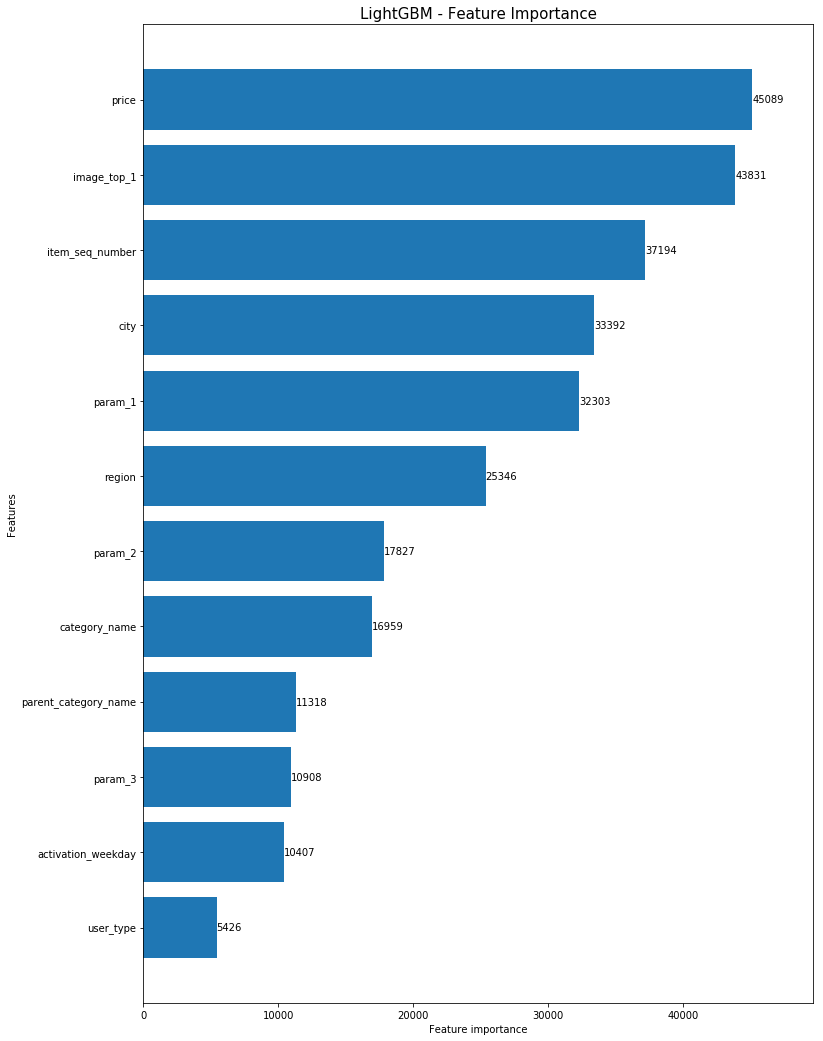

In [14]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()